In [ ]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

# Load the dataset

In [ ]:
from datasets import load_dataset

train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])

Using custom data configuration plain_text-6df5e50312c9f125
Found cached dataset parquet (C:/Users/USER/.cache/huggingface/datasets/parquet/plain_text-6df5e50312c9f125/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 5000
})

In [ ]:
test_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 2000
})

# Further split the train component to get the validation part of the data

In [ ]:
splits = train_ds.train_test_split(test_size=0.1)

In [ ]:
splits

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 500
    })
})

In [ ]:
train_ds = splits['train']
val_ds = splits['test']

In [ ]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 4500
})

In [ ]:
val_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 500
})

# Check the features of the training data

In [ ]:
train_ds.features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

# Observe the sample of training dataset

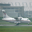

In [ ]:
train_ds[0]['img']

In [ ]:
train_ds[0]['label']

0

### Craete index to label and label to index dictionaries for passing as an input to the model

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
id2label[train_ds[0]['label']]

'airplane'

# Import feature extractor

In [ ]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Apply transforms to dataset for data augmentation, normalization and resizing

In [ ]:
from torchvision.transforms import (CenterCrop, # Crop the image from center while resizing
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, # Resize and data augmentation
                                    Resize,
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size), # Resize and data augmentation
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size), # Resize means no data augmentation only resizing
            CenterCrop(feature_extractor.size), # Crop the image from center while resizing
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

# Apply the transforms on training, testing and validation sets

In [ ]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

# Create Pytorch Dataloader

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples): # Collate_fn will ensure that all images are of same size
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


# Import Pretrained ViT Image Classifier

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Set the Training Arguments and Trainer

In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    remove_unused_columns=False,
)

# Define a compute_metrics function that will be used to compute metrics at evaluation

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

C:\Users\USER\AppData\Local\Temp/ipykernel_9928/1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


# Train the model

In [ ]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [ ]:
trainer.train()

D:\Anaconda\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4500
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 1350


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.827695,0.942000
2,1.471800,0.497834,0.958000
3,0.720900,0.411964,0.970000


***** Running Evaluation *****
  Num examples = 500
  Batch size = 4
Saving model checkpoint to test-cifar-10\checkpoint-450
Configuration saved in test-cifar-10\checkpoint-450\config.json
Model weights saved in test-cifar-10\checkpoint-450\pytorch_model.bin
Feature extractor saved in test-cifar-10\checkpoint-450\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 500
  Batch size = 4
Saving model checkpoint to test-cifar-10\checkpoint-900
Configuration saved in test-cifar-10\checkpoint-900\config.json
Model weights saved in test-cifar-10\checkpoint-900\pytorch_model.bin
Feature extractor saved in test-cifar-10\checkpoint-900\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 500
  Batch size = 4
Saving model checkpoint to test-cifar-10\checkpoint-1350
Configuration saved in test-cifar-10\checkpoint-1350\config.json
Model weights saved in test-cifar-10\checkpoint-1350\pytorch_model.bin
Feature extractor saved in test-cifar-10\checkpoint-1350\p

TrainOutput(global_step=1350, training_loss=0.959195556640625, metrics={'train_runtime': 1022.3003, 'train_samples_per_second': 13.206, 'train_steps_per_second': 1.321, 'total_flos': 1.046216869705728e+18, 'train_loss': 0.959195556640625, 'epoch': 3.0})

# Test the model

In [ ]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 2000
  Batch size = 4


#  Display confusion matrix and find the accuracy

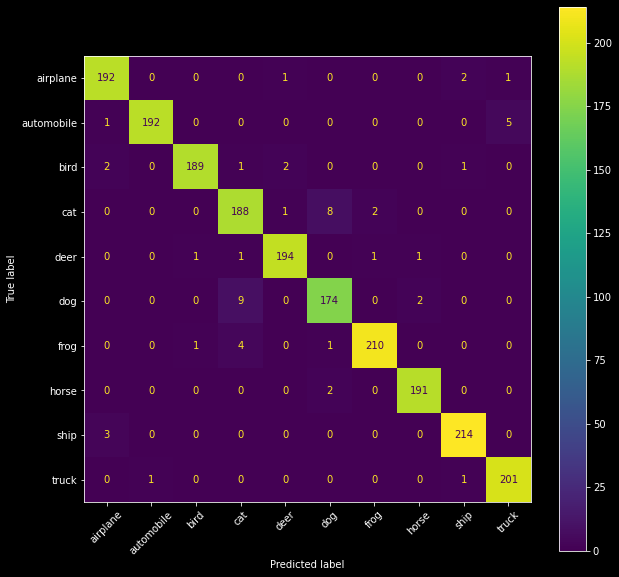

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
fig = disp.ax_.get_figure()
fig.set_figwidth(10)
fig.set_figheight(10)
plt.show()

In [ ]:
Accuracy = accuracy_score(y_true, y_pred, normalize=True).round(3)

In [ ]:
Accuracy

0.972